# Determining $\Sigma_{10}$ & $R_{10}$ of DESIJ1501+5208

Author: Md Mamun Hossain Nahid, S M Rafee Adnan, Anowar Shajib  <br>
Acknowledgement: Rajit

## Load data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [4]:
data, header = fits.getdata("DESIJ1501+5208_F140W_drz_sci.fits", header=True)

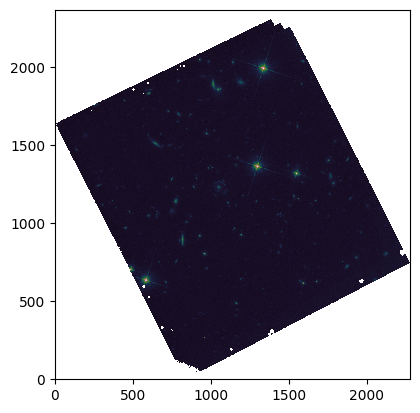

In [5]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [6]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

<ipython-input-7-eab7ae52f2d2>:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


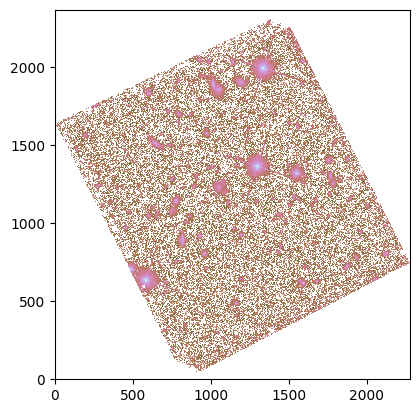

In [7]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [8]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.24040556699601626, 0.014961390589020055)

In [9]:
bkg_subtracted_data = data - bkg.background

In [10]:
threshold = 4 * bkg.background_rms

In [11]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [12]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=8,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [13]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2371, 2279)
nlabels: 645
labels: [  1   2   3   4   5 ... 641 642 643 644 645]


In [14]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 658
labels: [  1   2   3   4   5 ... 654 655 656 657 658]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

In [15]:
set_x_lim1, set_x_lim2 = 800, 1100 + 130
set_y_lim1, set_y_lim2 = 1000, 1300 + 120

<ipython-input-16-b23af21d1030>:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


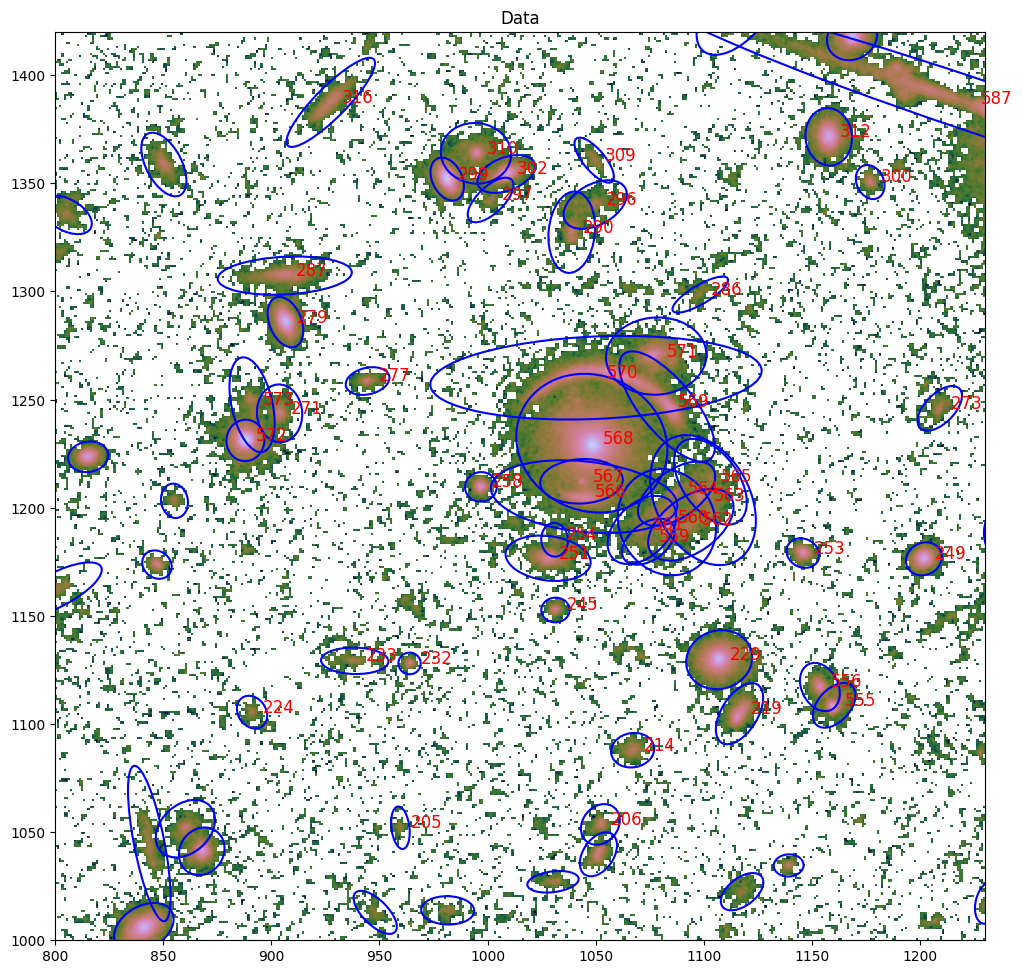

In [16]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

"""
#Before determining the central ID

for i in range(len(cat)):
    ax1.text(
         cat.xcentroid[i] + 5,
         cat.ycentroid[i],
         f"{i}",
         c="r",
         fontsize=12
    )
"""
# After determining the central ID
id_central = 568
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[id_central]) < 180
        and np.abs(cat.ycentroid[i] - cat.ycentroid[id_central]) < 180
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

<ipython-input-17-0ad7f9cacce0>:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


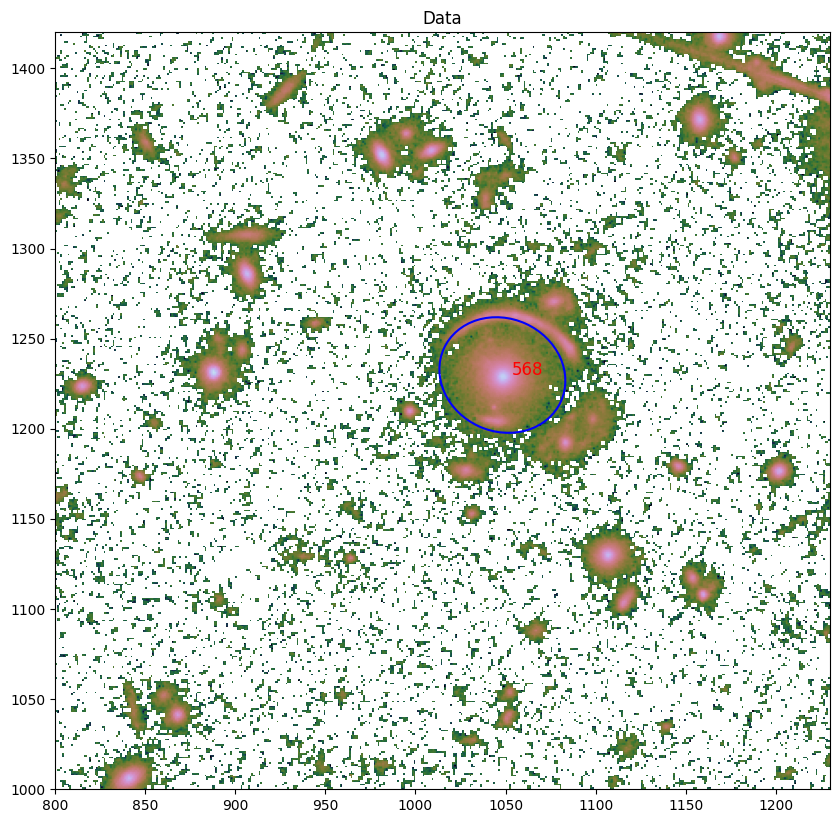

In [17]:
# object id of your central deflector/lens
id_central = 568

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
    # transform=ax1.transAxes
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [18]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [19]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of All Close galaxies within 20 arcseconds radius:", len(close_galaxies_all)
)

Number of All Close galaxies within 20 arcseconds radius: 65


In [20]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of Close galaxies (excluding the dim sources) within 20 arcseconds radius:",
    len(close_galaxies_1),
)

Number of Close galaxies (excluding the dim sources) within 20 arcseconds radius: 51


In [21]:
def distance_arcsec(pixel_distance):
    """
    Convert distance from unit of pixels into arcsec unit.

    :param pixel_distance: distance in unit of pixels
    :return: distance in arcsec unit
    """
    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

In [22]:
remove_list = [
    568,  # This is the central deflector
    566,  # Object is part of the lensed arc
    569,  # Object is part of the lensed arc
    570,  # Object is part of the lensed arc
    559,  # Halo of the objects 560 & 563
    561,  # Halo of the objects 560 & 563
    562,  # Halo of the objects 560 & 563
    564,  # Halo of the objects 560 & 563
    565,  # Halo of the objects 560 & 563
    254,  # Halo of the objects 251
]

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
567         18.269057          1.461525   17.133908    0.537012
571         50.076120          4.006090   51.247062    0.768467
560         50.386628          4.030930   69.044790    0.878838
258         55.113127          4.409050   14.951931    0.926341
251         56.920543          4.553643   28.261039    0.518586
563         57.754512          4.620361   42.973234    0.677501
245         78.948143          6.315851    5.681434    0.876158
286         85.044639          6.803571    2.884006    0.295082
290         97.969927          7.837594   15.282270    0.567030
277        107.592566          8.607405    6.257131    0.594901
253        110.027165          8.802173   14.633283    0.837625
296        110.346906          8.827752   11.288072    0.594476
229        116.140205          9.291216  122.067921    0.873275
297        121.791271          9.743302    4.755994    0.452175
302        130.612135         10.448971 

In [23]:
remove_list_1 = [
    568,  # This is the central deflector
    566,  # Object is part of the lensed arc
    569,  # Object is part of the lensed arc
    570,  # Object is part of the lensed arc
    559,  # Halo of the objects 560 & 563
    561,  # Halo of the objects 560 & 563
    562,  # Halo of the objects 560 & 563
    564,  # Halo of the objects 560 & 563
    565,  # Halo of the objects 560 & 563
]


df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
567         18.269057          1.461525   17.133908    0.537012
571         50.076120          4.006090   51.247062    0.768467
560         50.386628          4.030930   69.044790    0.878838
258         55.113127          4.409050   14.951931    0.926341
251         56.920543          4.553643   28.261039    0.518586
563         57.754512          4.620361   42.973234    0.677501
245         78.948143          6.315851    5.681434    0.876158
290         97.969927          7.837594   15.282270    0.567030
277        107.592566          8.607405    6.257131    0.594901
253        110.027165          8.802173   14.633283    0.837625
296        110.346906          8.827752   11.288072    0.594476
229        116.140205          9.291216  122.067921    0.873275
302        130.612135         10.448971   49.678920    0.542576
299        139.210758         11.136861  114.818400    0.654527
219        142.489102         11.399128 

## Determining Σ_10, Σ_10_flux_selected, Σ_20, Σ_20_flux_selected

In [24]:
set_x_lim1, set_x_lim2 = 870, 1180
set_y_lim1, set_y_lim2 = 1070, 1390

<ipython-input-25-052bcf243043>:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-25-052bcf243043>:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-25-052bcf243043>:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-25-052bcf243043>:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2



EXCLUDING DIM SOURCES
R 10: 8.802173208797251
R 20: 12.185435554142396
Sigma 10: 0.04108377164514739
Sigma 20: 0.04287439538563224

FOR All SOURCES
R 10: 8.607405267624875
R 20: 11.455756090797367
Sigma 10: 0.0429640906386594
Sigma 20: 0.04851014874936145


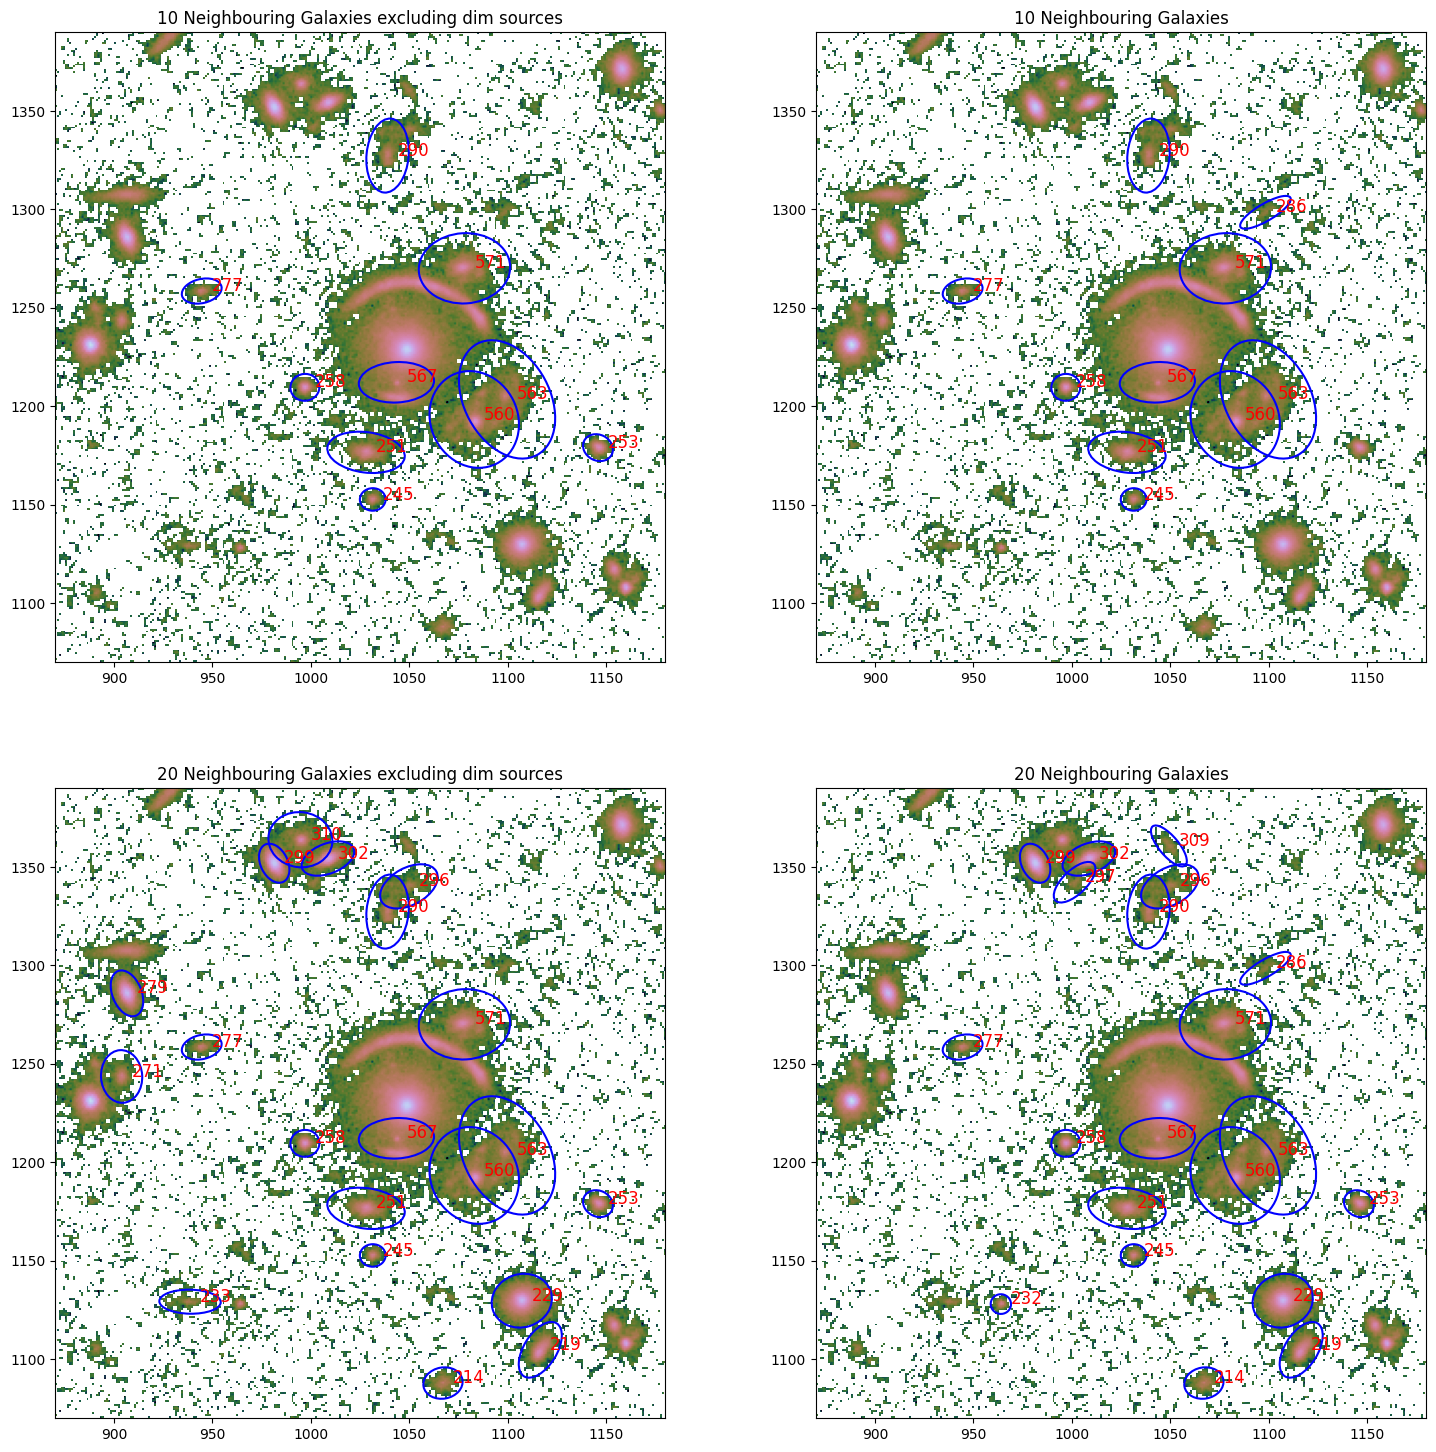

In [25]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(18, 18))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(arcsec)")]
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(arcsec)")]
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)

### Store the $\Sigma_{10}$, $\Sigma_{10\  \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20\  \rm flux\ selected}$ values in the YAML file

In [26]:
# convert the numpy.float64 values to floats

Sigma_10_all = Sigma_10_all.item()
Sigma_10_1 = Sigma_10_1.item()
Sigma_20_all = Sigma_20_all.item()
Sigma_20_1 = Sigma_20_1.item()

In [27]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1501+5208_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10": Sigma_10_all,
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20": Sigma_20_all,
    "Sigma_20_flux_selected": Sigma_20_1,
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [29]:
# Read the YAML file using safe_load

with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 0.7205276678934682, 'Sigma_10': 0.0429640906386594, 'Sigma_10_flux_selected': 0.04108377164514739, 'Sigma_20': 0.04851014874936145, 'Sigma_20_flux_selected': 0.04287439538563224, 'center_x_light': [0.1432446742122358, 0.0008889154287016754, 0.0009319579631293096], 'center_x_mass': [0.058598016567189035, 0.006702337114232293, 0.006031763710937527], 'center_y_light': [-0.13761715729908422, 0.0007686040139971151, 0.0007523707046324102], 'center_y_mass': [-0.5096104909433775, 0.018346213251418553, 0.019112186449885882], 'gamma': [2.144060299504608, 0.02863136405684008, 0.02698243532947986], 'gamma_shear': [0.10730543894702567, 0.0061416043730661285, 0.006302747094289116], 'phi_light': [0.46882311463832016, 0.04982981394332564, 0.04753113723271507], 'phi_mass': [-0.7644187046338623, 0.10699233249422724, 0.09021138910958693], 'phi_shear': [0.05186381027451778, 0.011692279036570663, 0.013632563624703421], 'q_light': [0.9440798440047046, 0.004754